# 1. Import libary

In [4]:
import os
import time
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from PIL import ImageFont, ImageDraw, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from rembg import remove
from PIL import Image
from rembg import new_session

# 1.1 Functions and variable used in the project

In [3]:
# HÀM SỬ DỤNG TIẾNG VIỆT

# Tải font chữ hỗ trợ tiếng Việt (ví dụ: Arial Unicode MS hoặc Noto Sans)
font_path = "arial.ttf"  # Bạn cần có file font .ttf hỗ trợ Unicode
font = ImageFont.truetype(font_path, 32)  # Kích thước chữ

def draw_text_vietnamese(image, text, position, text_color=(0, 255, 255)):
    # Chuyển ảnh từ OpenCV sang PIL
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_img)
    
    # Vẽ chữ lên ảnh
    draw.text(position, text, font=font, fill=text_color)
    
    # Chuyển ảnh từ PIL về OpenCV
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

In [4]:
# KHAI BÁO CÁC BIẾN MP

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# Khởi tạo và gắn biến xử lý bàn tay trong Mediapipe
mp_hands = mp.solutions.hands  

# khởi tạo và gắn biến vẽ hình bàn tay
mp_drawing = mp.solutions.drawing_utils  

# Khởi tạo và gắn biến hỗ trợ kiểu vẽ (có sẵn màu sắc, độ dày, v.v.)
mp_drawing_styles = mp.solutions.drawing_styles  

# Tạo một đối tượng 'Hands' để nhận diện bàn tay trong ảnh hoặc video
# static_image_mode chế độ ảnh tĩnh (True: chỉ xử lý ảnh đơn lẻ, False: xử lý video liên tục)
# min_detection_confidence Xác suất tối thiểu để mô hình chấp nhận một bàn tay
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.5, max_num_hands = 1)

# Khởi tạo Mediapipe Selfie Segmentation
mp_selfie_segmentation = mp.solutions.selfie_segmentation.SelfieSegmentation(model_selection=1)

In [5]:
# CÁC HÀM XÁC ĐỊNH BÀN TAY VÀ HỖ TRỢ THU THẬP DỮ LIỆU

# xác định bàn tay
def extract_hands(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    h, w, _ = frame.shape
    hand_images = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            x_min, y_min = w, h
            x_max, y_max = 0, 0
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)

            padding = 20  # Thêm khoảng trống xung quanh bàn tay
            x_min, y_min = max(0, x_min - padding), max(0, y_min - padding)
            x_max, y_max = min(w, x_max + padding), min(h, y_max + padding)
            hand_img = frame[y_min:y_max, x_min:x_max]
            if hand_img.size > 0:
                hand_images.append(hand_img)
    
    return hand_images

def is_hand_over_face(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_face = face_detection.process(rgb_frame)
    results_hands = hands.process(rgb_frame)

    h, w, _ = frame.shape
    face_boxes = []

    # Lấy tọa độ khuôn mặt, kiểm tra kích thước hợp lệ
    if results_face.detections:
        for detection in results_face.detections:
            bbox = detection.location_data.relative_bounding_box
            x1 = max(0, int(bbox.xmin * w))
            y1 = max(0, int(bbox.ymin * h))
            x2 = min(w, int((bbox.xmin + bbox.width) * w))
            y2 = min(h, int((bbox.ymin + bbox.height) * h))
            face_width = x2 - x1
            face_height = y2 - y1

            # Bỏ qua những "khuôn mặt" quá nhỏ hoặc quá lớn
            if face_width < w * 0.1 or face_height < h * 0.1:  
                continue  # Bỏ qua do có thể là khủy tay hoặc nhiễu

            face_boxes.append((x1, y1, x2, y2))

    # Nếu không tìm thấy khuôn mặt hợp lệ thì không kiểm tra tay
    if not face_boxes:
        return False  

    # Kiểm tra nếu có bàn tay và nó nằm trong vùng mặt
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            num_points_inside = 0  # Đếm số keypoint nằm trong vùng mặt

            for lm in hand_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)

                for (fx1, fy1, fx2, fy2) in face_boxes:
                    if fx1 <= cx <= fx2 and fy1 <= cy <= fy2:
                        num_points_inside += 1  # Đếm số điểm nằm trong vùng mặt

            # Nếu có ít nhất 4 điểm của bàn tay nằm trên mặt thì mới xác định là đang che mặt
            if num_points_inside >= 4:
                return True  

    return False  # Bàn tay không nằm trên mặt

# Hiển thị khung khuôn mặt và bàn tay trên frame.
# Nếu tay che mặt -> đổi màu khung tay thành đỏ và báo dừng thu thập.

#Kiểm tra hai khung có giao nhau không
def check_overlap(box1, box2):
    x1_a, y1_a, x2_a, y2_a = box1
    x1_b, y1_b, x2_b, y2_b = box2

    return not (x2_a < x1_b or x2_b < x1_a or y2_a < y1_b or y2_b < y1_a)

#vẽ khung cho mặt và tay
def draw_face_hand_boxes(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_face = face_detection.process(rgb_frame)
    results_hands = hands.process(rgb_frame)

    h, w, _ = frame.shape
    face_boxes = []
    hand_boxes = []
    hand_over_face = False

    # Vẽ khung khuôn mặt (màu xanh dương)
    if results_face.detections:
        for detection in results_face.detections:
            bbox = detection.location_data.relative_bounding_box
            x1, y1 = int(bbox.xmin * w), int(bbox.ymin * h)
            x2, y2 = int((bbox.xmin + bbox.width) * w), int((bbox.ymin + bbox.height) * h)
            face_boxes.append((x1, y1, x2, y2))
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Xanh dương

    # Vẽ khung bàn tay (màu xanh lá hoặc đỏ)
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            x_min, y_min = w, h
            x_max, y_max = 0, 0
            for lm in hand_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)
                x_min, y_min = min(x_min, cx), min(y_min, cy)
                x_max, y_max = max(x_max, cx), max(y_max, cy)

            hand_boxes.append((x_min, y_min, x_max, y_max))

            # Kiểm tra nếu tay chạm vào khuôn mặt
            is_covering = any(check_overlap((x_min, y_min, x_max, y_max), face_box) for face_box in face_boxes)
            hand_over_face |= is_covering  # Nếu có ít nhất 1 bàn tay che mặt -> báo hiệu true

            color = (0, 0, 255) if is_covering else (0, 255, 0)  # Đỏ nếu che mặt, xanh lá nếu không
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)

    return frame, hand_over_face

#Phát hiện bàn tay trong khung hình.
def detect_hand(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        return True  # Có bàn tay
    return False  # Không có bàn tay

In [6]:
# Lấy số tiếp theo trông dữ liệu để thu thập dữ liệu
def get_next_index(action_dir):
    existing_files = os.listdir(action_dir)
    indices = []
    for file in existing_files:
        try:
            index = int(file.split(".")[0])  # Lấy số thứ tự từ tên file (VD: "25.jpg" → 25)
            indices.append(index)
        except ValueError:
            continue  # Bỏ qua file không hợp lệ
    return max(indices, default=-1) + 1  # Nếu không có ảnh nào, bắt đầu từ 0

# 2. Collect image

In [ ]:
# KHAI BÁO CÁC HÀNH ĐỘNG SẼ THU THẬP DỮ LIỆU

# https://www.youtube.com/watch?v=6_gXiBe9y9A video về ngôn ngữ ký hiệu cho alphabet
# hành động để phát hiện 0-9 a-z
actions = np.array([str(i) for i in range(10)] + [chr(i) for i in range(97, 123)])

# hành đồng từ 0-4
# actions = np.array(['0', '1', '2', '3', '4'])

# hành đồng từ 5-9
# actions = np.array(['5', '6', '7', '8', '9'])

# hành đồng từ a-e
# actions = np.array(['a', 'b', 'c', 'd', 'e'])

# hành đồng từ f-j
# actions = np.array(['f', 'g', 'h', 'i'])

# hành đồng từ k-o
# actions = np.array(['k', 'l', 'm', 'n']) #'o' dung chung cho 0

# hành đồng từ p-t
# actions = np.array(['p', 'q', 'r', 's', 't'])

# hành đồng từ u-z
# actions = np.array(['u', 'v', 'w', 'x', 'y'])

# actions = np.array(['z', 'j']) # chưa làm được vì cần thực hiện động tác động có thể sẽ cần làm bằng cách của video này https://www.youtube.com/watch?v=doDUihpj6ro
#hoặc 1 cách khác

In [ ]:
dataset_size = 800 # Thu thập lại toàn bộ dataset của tùng actions

# Cấu hình thu thập dữ liệu
frame_rate = 5  # Chụp ảnh 5 lần/giây
prev_time = time.time()
pause = False

# messages = [
#     "Di chuyển tay lên",
#     "Di chuyển tay xuống",
#     "Di chuyển tay sang trái",
#     "Di chuyển tay sang phải",
#     "Xoay vòng quanh màn hình",
#     "Hướng tay lên",
#     "Hướng tay xuống",
#     "Hướng tay qua trái",
#     "Hướng tay qua phải",
#     "Giữ cổ tay xoay bàn tay",
#     "Giữ cổ tay và hướng bàn tay xoay bàn tay dần qua trái",
#     "Giữ cổ tay và hướng bàn tay xoay dần qua phải"
# ]

DATA_DIR = "./data_cnn"
os.makedirs(DATA_DIR, exist_ok=True)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

for action in actions:
    action_dir = os.path.join(DATA_DIR, str(action))
    os.makedirs(action_dir, exist_ok=True)

    # Hiển thị hướng dẫn trước khi bắt đầu thu thập dữ liệu
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        frame = draw_text_vietnamese(frame, f"Thu thập dữ liệu cho ký hiệu: {action}", (50, 100), (0, 255, 0))
        frame = draw_text_vietnamese(frame, "Nhấn 'q' để bắt đầu!", (100, 50), (0, 255, 0))

        cv2.imshow('frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q') and not pause:
            break

    counter = 0
    start_time = time.time()
    message_index = 0
    waiting_for_switch = False  # Biến để theo dõi trạng thái "Đổi tay"
    
    while counter < dataset_size:
        ret, frame = cap.read()
        if not ret:
            continue

        elapsed_time = time.time() - start_time

        # Kiểm tra bàn tay có nằm trên khuôn mặt không
        # if is_hand_over_face(frame):
        #     frame = draw_text_vietnamese(frame, "Bàn tay che mặt - Tạm dừng", (50, 50), (0, 0, 255))
        #     prev_time = time.time()  # Dừng đếm thời gian khi tay che mặt
        #     cv2.imshow('frame', frame)
        #     cv2.waitKey(1)
        #     continue  # Bỏ qua bước thu thập nếu tay đang che mặt
        
        # Kiểm tra nếu không phát hiện bàn tay thì tạm dừng   
        if not detect_hand(frame):
            frame = draw_text_vietnamese(frame, "Không phát hiện tay - Tạm dừng", (50, 50), (0, 0, 255))
            prev_time = time.time()  # Dừng đếm thời gian khi không thấy tay
            cv2.imshow('frame', frame)
            cv2.waitKey(1)
            continue  # Bỏ qua ghi dữ liệu nếu không có tay
    
        # Kiểm tra nếu đang ở trạng thái tạm dừng
        if pause:
            frame = draw_text_vietnamese(frame, "TẠM DỪNG - Nhấn SPACE để tiếp tục", (50, 50), (0, 255, 255))
            prev_time = time.time()
            cv2.imshow('frame', frame)
            key = cv2.waitKey(0)  # Chờ nhấn phím
            if key == ord(' '):  # Nếu nhấn SPACE thì tiếp tục
                pause = False
                start_time = time.time()  # Reset thời gian
            continue
        
        # Cập nhật tin nhắn hướng dẫn hành động
        # if not waiting_for_switch and elapsed_time > 5:
        #     message_index += 1
        #     start_time = time.time()
        #     if message_index == len(messages):
        #         waiting_for_switch = True  # Chuyển vào trạng thái chờ đổi tay
        #         message_index = 0  
        
        # Hiển thị tin nhắn đổi tay
        # if waiting_for_switch:
        #     current_message = "Đổi tay - Nhấn SPACE để tiếp tục!"
        # else:
        #     current_message = messages[message_index]

        # frame = draw_text_vietnamese(frame, current_message, (30, 20), (255, 0, 0))
        frame = draw_text_vietnamese(frame, f"Thu thập: {counter}/{dataset_size}", (30, 70), (0, 255, 0))

        cv2.imshow('frame', frame)

        # Nếu đang trong trạng thái đổi tay, chờ đến khi nhấn SPACE
        if waiting_for_switch:
            key = cv2.waitKey(0)  # Chờ nhấn phím
            if key == ord(' '):  # Nếu nhấn SPACE, tiếp tục thu thập dữ liệu
                waiting_for_switch = False  # Thoát trạng thái đổi tay
                start_time = time.time()  # Reset thời gian đếm hành động tiếp theo
        else:
            # Lưu ảnh nếu đủ thời gian giữa các lần chụp
            if time.time() - prev_time > 0.2:  
                hand_images = extract_hands(frame)  # Cắt ảnh bàn tay
                for idx, hand_img in enumerate(hand_images):
                    if hand_img.size > 0:
                        file_path = os.path.join(action_dir, f"{counter}.jpg")
                        cv2.imwrite(file_path, hand_img)
                counter += 1
                prev_time = time.time()
                
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q') and not pause:
            break
        elif key == 27:  # Nếu nhấn ESC, chuyển sang trạng thái tạm dừng
            pause = True 

cap.release()
cv2.destroyAllWindows()


In [6]:
actions = np.array(['y'])

In [ ]:
add_dataset_size = 300 # Bổ sung dataset bị thiếu mà ko cần ghi lại toàn bộ
# Cấu hình thu thập dữ liệu
frame_rate = 5  # Chụp ảnh 5 lần/giây
prev_time = time.time()
pause = False

# messages = [
#     "Di chuyển tay lên",
#     "Di chuyển tay xuống",
#     "Di chuyển tay sang trái",
#     "Di chuyển tay sang phải",
#     "Xoay vòng quanh màn hình",
#     "Hướng tay lên",
#     "Hướng tay xuống",
#     "Hướng tay qua trái",
#     "Hướng tay qua phải",
#     "Giữ cổ tay xoay bàn tay",
#     "Giữ cổ tay và hướng bàn tay xoay bàn tay dần qua trái",
#     "Giữ cổ tay và hướng bàn tay xoay dần qua phải"
# ]

DATA_DIR = "./data_cnn"
os.makedirs(DATA_DIR, exist_ok=True)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

for action in actions:
    action_dir = os.path.join(DATA_DIR, str(action))
    os.makedirs(action_dir, exist_ok=True)

    # Hiển thị hướng dẫn trước khi bắt đầu thu thập dữ liệu
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        frame = draw_text_vietnamese(frame, f"Thu thập dữ liệu cho ký hiệu: {action}", (50, 100), (255, 0, 0))
        frame = draw_text_vietnamese(frame, "Nhấn 'q' để bắt đầu!", (100, 50), (0, 255, 0))

        cv2.imshow('frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q') and not pause:
            break

    counter = 0
    start_time = time.time()
    message_index = 0
    # waiting_for_switch = False  # Biến để theo dõi trạng thái "Đổi tay"
    
    # Đếm số lượng ảnh đã có sẵn trong thư mục
    existing_images = get_next_index(action_dir)
    counter = get_next_index(action_dir)  # Bắt đầu từ số ảnh hiện tại
    current_counter = counter
    
    while counter < existing_images + add_dataset_size:
        ret, frame = cap.read()
        if not ret:
            continue

        elapsed_time = time.time() - start_time

        # Kiểm tra bàn tay có nằm trên khuôn mặt không
        # if is_hand_over_face(frame):
        #     frame = draw_text_vietnamese(frame, "Bàn tay che mặt - Tạm dừng", (50, 50), (0, 0, 255))
        #     prev_time = time.time()  # Dừng đếm thời gian khi tay che mặt
        #     cv2.imshow('frame', frame)
        #     cv2.waitKey(1)
        #     continue  # Bỏ qua bước thu thập nếu tay đang che mặt
        
        # Kiểm tra nếu không phát hiện bàn tay thì tạm dừng   
        if not detect_hand(frame):
            frame = draw_text_vietnamese(frame, "Không phát hiện tay - Tạm dừng", (50, 50), (0, 0, 255))
            prev_time = time.time()  # Dừng đếm thời gian khi không thấy tay
            cv2.imshow('frame', frame)
            cv2.waitKey(1)
            continue  # Bỏ qua ghi dữ liệu nếu không có tay
        
        # Kiểm tra nếu đang ở trạng thái tạm dừng
        if pause:
            frame = draw_text_vietnamese(frame, "TẠM DỪNG - Nhấn SPACE để tiếp tục", (50, 50), (0, 255, 255))
            prev_time = time.time()
            cv2.imshow('frame', frame)
            key = cv2.waitKey(0)  # Chờ nhấn phím
            if key == ord(' '):  # Nếu nhấn SPACE thì tiếp tục
                pause = False
                start_time = time.time()  # Reset thời gian
            continue
        
        # # Cập nhật tin nhắn hướng dẫn hành động
        # if not waiting_for_switch and elapsed_time > 5:
        #     message_index += 1
        #     start_time = time.time()
        #     if message_index == len(messages):
        #         waiting_for_switch = True  # Chuyển vào trạng thái chờ đổi tay
        #         message_index = 0  
        
        # # Hiển thị tin nhắn đổi tay
        # if waiting_for_switch:
        #     current_message = "Đổi tay - Nhấn SPACE để tiếp tục!"
        # else:
        #     current_message = messages[message_index]

        # frame = draw_text_vietnamese(frame, current_message, (30, 20), (255, 0, 0))
        frame = draw_text_vietnamese(frame, f"Thu thập dữ liệu cho ký hiệu: {action}", (30, 40), (255, 0, 0))
        frame = draw_text_vietnamese(frame, f"Thu thập: {counter}/{current_counter + add_dataset_size}", (30, 70), (255, 0, 0))

        cv2.imshow('frame', frame)

        # Nếu đang trong trạng thái đổi tay, chờ đến khi nhấn SPACE
        if waiting_for_switch:
            key = cv2.waitKey(0)  # Chờ nhấn phím
            if key == ord(' '):  # Nếu nhấn SPACE, tiếp tục thu thập dữ liệu
                waiting_for_switch = False  # Thoát trạng thái đổi tay
                start_time = time.time()  # Reset thời gian đếm hành động tiếp theo
        else:
            # Lưu ảnh nếu đủ thời gian giữa các lần chụp
            if time.time() - prev_time > 0.2:  
                hand_images = extract_hands(frame)  # Cắt ảnh bàn tay
                images_saved = 0  # Đếm số ảnh thực sự được lưu

                for idx, hand_img in enumerate(hand_images):
                    if hand_img.size > 0:
                        file_path = os.path.join(action_dir, f"{counter}.jpg")
                        cv2.imwrite(file_path, hand_img)
                        images_saved += 1  # Chỉ tăng nếu ảnh được lưu
                if images_saved > 0:
                    counter += 1  # Chỉ tăng nếu có ảnh được lưu
                    prev_time = time.time()

                
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            break
        elif key == 27:  # Nếu nhấn ESC, chuyển sang trạng thái tạm dừng
            pause = True 

cap.release()
cv2.destroyAllWindows()


# 3.Create database || Data processing

In [15]:
# HÀM XỮ LÝ NỀN

# Xử lý ảnh trước khi xóa nền
def preprocess_image(input_path, output_path):
    image = cv2.imread(input_path)

    # Chuyển sang grayscale để tăng độ tương phản
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Cân bằng độ sáng
    
    # Làm sắc nét ảnh
    kernel = np.array([[0, -1, 0],
                       [-1,  5,-1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(gray, -1, kernel)

    # Chuyển lại sang ảnh màu
    processed = cv2.cvtColor(sharp, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(output_path, processed)

# Hàm xóa nền
def remove_bg(input_path, output_path):
    session = new_session("u2net_human_seg")  # Thử model khác
    input_img = Image.open(input_path)
    output_img = remove(input_img, session)
    output_img.save(output_path, "PNG")

# Hàm thay thế nền
def replace_background(hand_image_path, background_image_path, output_path):
    hand_img = cv2.imread(hand_image_path, cv2.IMREAD_UNCHANGED)  # Đọc ảnh không nền
    background = cv2.imread(background_image_path)  # Đọc ảnh nền

    if hand_img is None or background is None:
        raise ValueError(f"Lỗi đọc ảnh: {hand_image_path} hoặc {background_image_path}")

    # Resize background theo kích thước ảnh tay
    background = cv2.resize(background, (hand_img.shape[1], hand_img.shape[0]))

    # Lấy phần mask của hình bàn tay
    mask = hand_img[:, :, 3]  # Kênh alpha (vì đã xóa nền)
    mask_inv = cv2.bitwise_not(mask)

    # Tạo foreground và background mới
    fg = cv2.bitwise_and(hand_img[:, :, :3], hand_img[:, :, :3], mask=mask)
    bg = cv2.bitwise_and(background, background, mask=mask_inv)

    # Kết hợp ảnh
    result = cv2.add(bg, fg)
    cv2.imwrite(output_path, result)
    
# Xử lý ảnh sau khi xóa nền 
def fix_alpha_channel(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if img.shape[2] == 4:
        alpha = img[:, :, 3]

        # Loại bỏ nhiễu alpha bằng cách tăng cường độ nét
        alpha = cv2.threshold(alpha, 100, 255, cv2.THRESH_BINARY)[1]
        img[:, :, 3] = alpha  # Cập nhật lại alpha

    cv2.imwrite(output_path, img)

In [ ]:
# THỰC HIỆN XỮ LÝ NỀN

# Thư mục chứa dataset gốc
DATA_DIR = "./data_cnn"
# Thư mục chứa ảnh nền
BACKGROUND_DIR = "./backgrounds"
# Thư mục lưu dataset mới
OUTPUT_DIR = "./data_background_augmented"
    
# Đọc danh sách background
background_files = [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) if f.endswith((".jpg", ".png"))]
    
# Đảm bảo thư mục output tồn tại
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Lặp qua từng folder trong dataset
for label in os.listdir(DATA_DIR):
    label_path = os.path.join(DATA_DIR, label)
    if not os.path.isdir(label_path):
        continue

    # Tạo thư mục mới để lưu ảnh đã thay nền
    output_label_path = os.path.join(OUTPUT_DIR, label)
    os.makedirs(output_label_path, exist_ok=True)

    # Lặp qua từng ảnh trong thư mục
    for img_name in os.listdir(label_path):
        if not img_name.endswith(".jpg"):
            continue

        img_path = os.path.join(label_path, img_name)
        processed_path = os.path.join(output_label_path, "preprocessed_" + img_name)
        temp_output_path = os.path.join(output_label_path, "no_bg_" + img_name.replace(".jpg", ".png"))  # Lưu ảnh PNG không nền
        final_output_path = os.path.join(output_label_path, img_name)  # Ảnh cuối sau khi thay nền

        try:
            preprocess_image(img_path, processed_path)
            # Bước 1: Xóa nền
            remove_bg(img_path, temp_output_path)
            fix_alpha_channel(temp_output_path, temp_output_path)
            
            # Chọn background ngẫu nhiên
            random_bg = random.choice(background_files)

            # Bước 2: Thay nền
            replace_background(temp_output_path, random_bg, final_output_path)

            # Xóa ảnh không nền (nếu không cần lưu)
            os.remove(temp_output_path)

            print(f"✔ Đã xử lý: {img_name}")
        except Exception as e:
            print(f"❌ Lỗi với {img_name}: {e}")

print("✅ Hoàn thành tạo dataset mới với nền thay thế!")


In [27]:
# THỰC HIỆN GẮN NHẢN XỮ LÝ CHO TOÀN BỘ DỮ LIỆU

# Augmentation Layer

data_augmentation = keras.Sequential([
    # layers.RandomRotation(0.1),        # Xoay ngẫu nhiên trong khoảng -10% đến +10%
    layers.RandomZoom(0.2),            # Zoom-in hoặc Zoom-out tối đa 20%
    # layers.RandomTranslation(0.1, 0.1),# Dịch ngang và dọc tối đa 10%
    layers.RandomBrightness(0.001),      # Điều chỉnh độ sáng trong khoảng [-0.1%, +0.1%] đã thứ với nhiều tỷ lệ 0,1% là tốt nhất và cũng có thay đổi độ sáng đáng kễ
    layers.RandomContrast(0.2),        # Điều chỉnh tương phản trong khoảng [-20%, +20%]
    layers.GaussianNoise(0.02),        # Thêm nhiễu Gaussian để mô phỏng điều kiện thực tế
])


DATA_DIR = "./data_cnn"  # Đường dẫn đến dữ liệu
data = []
labels = []

# **Load toàn bộ dataset**
for label in os.listdir(DATA_DIR):  
    label_path = os.path.join(DATA_DIR, label)
    if not os.path.isdir(label_path):  
        continue  # Nếu không phải thư mục, bỏ qua

    img_list = os.listdir(label_path)

    for img_name in img_list:
        img_path = os.path.join(label_path, img_name)
        
        img = cv2.imread(img_path)
        if img is None:  
            continue  

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))

        # Chuyển sang tensor để Augment
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)  
        img_tensor = tf.expand_dims(img_tensor, axis=0)

        # Áp dụng Augmentation
        img_aug = data_augmentation(img_tensor)
        img_aug = tf.squeeze(img_aug).numpy()  
        img_aug = img_aug / 255.0  # Chuẩn hóa về [0,1]
        
        # img = img / 255.0

        # Lưu ảnh vào danh sách
        data.append(img_aug)
        labels.append(label)  

# Chuyển data thành numpy array
data = np.array(data, dtype=np.float32) 

# Gán nhãn thành số (gộp tất cả vào)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Chuyển thành numpy array
labels = np.array(labels)

# Lưu dữ sau này sử dụng nếu cần
np.save("x_train(full_data_aug).npy", data)
np.save("y_train(full_label_aug).npy", labels)

In [ ]:
# THỰC HIỆN GẮN NHẢN XỮ LÝ CHO TỪNG MODEL NHỎ

# Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.05),  # Xoay nhẹ (5%)
    layers.RandomZoom(0.1),       # Zoom 10%
    layers.RandomTranslation(0.1, 0.1),  # Dịch chuyển nhẹ
    layers.RandomBrightness(0.1), # Điều chỉnh độ sáng
    layers.Lambda(lambda x: tf.image.stateless_random_contrast(x, 0.8, 1.2, seed=(42, 42))),  # Tương phản
])

# Chỉ lấy dữ liệu từ 0-9
# VALID_LABELS = list("0123456789")
# Chỉ lấy dữ liệu từ a-i
# VALID_LABELS = list("abcdefghi")
# Chỉ lấy dữ liệu từ k-t
# VALID_LABELS = list("klmnpqrst")
# Chỉ lấy dữ liệu từ u-t
VALID_LABELS = list("uvwxy")

DATA_DIR = "./data_cnn"
data = []
labels = []

# Load dữ liệu
for label in os.listdir(DATA_DIR):  
    if label not in VALID_LABELS:  # Chỉ lấy ký tự theo list
        continue
    
    label_path = os.path.join(DATA_DIR, label)
    if not os.path.isdir(label_path):  
        continue

    img_list = os.listdir(label_path)

    for img_name in img_list:
        img_path = os.path.join(label_path, img_name)
        
        img = cv2.imread(img_path)
        if img is None:  
            continue  

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))

        # Chuyển sang tensor để Augment
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)  
        img_tensor = tf.expand_dims(img_tensor, axis=0)

        # Áp dụng Augmentation
        img_aug = data_augmentation(img_tensor)
        img_aug = tf.squeeze(img_aug).numpy()  
        img_aug = img_aug / 255.0  # Chuẩn hóa về [0,1]

        # Lưu ảnh vào danh sách
        data.append(img_aug)
        labels.append(label)  

# Chuyển data thành numpy array
data = np.array(data, dtype=np.float32) 

# Gán nhãn thành số
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [6]:
data = np.load("X_train(full_data).npy")
labels = np.load("y_train(full_label).npy")

In [7]:
# TÁCH TRAIN TEST SET *LƯU Ý khi sử dụng one hot (to categorical)
# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=7, stratify=labels)

# Chuyển thành one-hot
num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

print("Dữ liệu đã load xong! Số lượng ảnh:", len(data))
print(f"Kích thước tệp huấn luyện: {len(X_train)}, Kích thước tệp kiểm tra: {len(X_test)}")
print(f"X_train Shape: {X_train.shape}")  # (số ảnh, 64, 64, 3)

Dữ liệu đã load xong! Số lượng ảnh: 40131
Kích thước tệp huấn luyện: 32104, Kích thước tệp kiểm tra: 8027
X_train Shape: (32104, 64, 64, 3)


In [ ]:
# TÁCH TRAIN TEST SET *LƯU Ý khi không dùng one hot encoder
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 7, stratify = labels)

# In thông tin dataset
print("Dữ liệu đã load xong! Số lượng ảnh:", len(data))
print(f"Kích thước tệp huấn luyện: {len(X_train)}, Kích thước tệp kiểm tra: {len(X_test)}")
print(f"X_train Shape: {X_train.shape}")  # (số ảnh, 64, 64, 3)

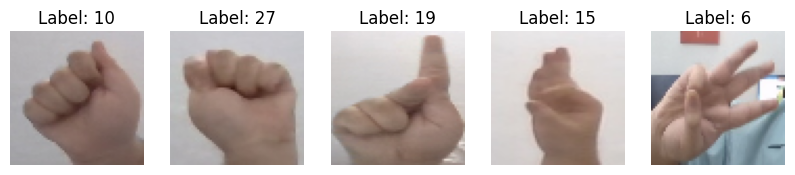

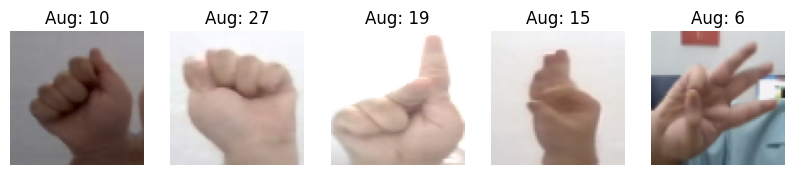

In [ ]:
# thử nghiệm data aug

# Định nghĩa lớp Augmentation
data_augmentation = keras.Sequential([
    # layers.RandomRotation(0.1),        # Xoay ngẫu nhiên trong khoảng -10% đến +10%
    layers.RandomZoom(0.2),            # Zoom-in hoặc Zoom-out tối đa 20%
    # layers.RandomTranslation(0.1, 0.1),# Dịch ngang và dọc tối đa 10%
    layers.RandomBrightness(0.001),      # Điều chỉnh độ sáng trong khoảng [-0.1%, +0.1%] đã thứ với nhiều tỷ lệ 0,1% là tốt nhất và cũng có thay đổi độ sáng đáng kễ
    layers.RandomContrast(0.2),        # Điều chỉnh tương phản trong khoảng [-20%, +20%]
    # layers.GaussianNoise(0.02),        # Thêm nhiễu Gaussian để mô phỏng điều kiện thực tế
])

# Chọn ngẫu nhiên 5 ảnh từ data
num_samples = 5
random_indices = random.sample(range(len(data)), num_samples)

# Hiển thị ảnh gốc
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(data[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")

# Hiển thị ảnh đã Augment
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    img_tensor = tf.convert_to_tensor(data[idx], dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Thêm batch dimension

    augmented_img = data_augmentation(img_tensor, training=True)  # Kích hoạt augmentation
    augmented_img = tf.squeeze(augmented_img).numpy()  # Loại bỏ batch dimension
    augmented_img = np.clip(augmented_img, 0, 1)  # Đảm bảo nằm trong khoảng [0,1]

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(augmented_img)
    plt.title(f"Aug: {labels[idx]}")
    plt.axis("off")

plt.show()


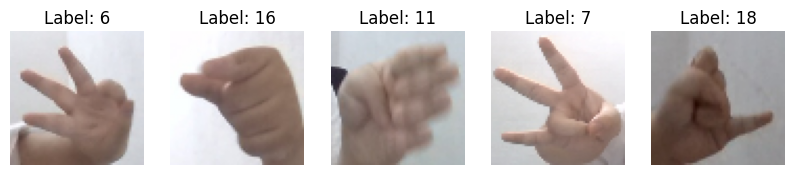

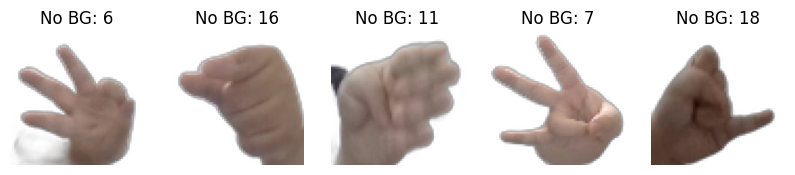

In [ ]:
# Kiểm tra ảnh khi thực hiện xóa nền
# Hàm xóa nền
def remove_bg(image):
    session = new_session("u2net")  # Sử dụng U²-Net
    image = (image * 255).astype(np.uint8)  # Chuyển về uint8 nếu ảnh đang ở dạng float32
    output = remove(image, session=session)  # Xóa nền
    return output

# Chọn ngẫu nhiên 5 ảnh từ data
num_samples = 5
random_indices = random.sample(range(len(data)), num_samples)

# Hiển thị ảnh gốc
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(data[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")

# Hiển thị ảnh sau khi xóa nền
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    img_no_bg = remove_bg(data[idx])

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(img_no_bg)
    plt.title(f"No BG: {labels[idx]}")
    plt.axis("off")

plt.show()


# 4. Train model

In [33]:
del model

In [8]:
model = tf.keras.models.load_model("fully_model_130e_with_Aug.keras")

In [ ]:

# Khởi tạo model CNN
model = Sequential([
    # Layer 1: Trích xuất đặc trưng từ ảnh
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # 32 bộ lọc, kernel 3x3, hàm kích hoạt ReLU
    MaxPooling2D(pool_size=(2, 2)),  # Giảm kích thước ảnh xuống còn một nửa (downsampling)
    Dropout(0.2),
    
    # Layer 2: Tăng độ trừu tượng của đặc trưng
    Conv2D(64, (3, 3), activation='relu'),  # 64 bộ lọc, kernel 3x3
    MaxPooling2D(pool_size=(2, 2)),  # Tiếp tục giảm kích thước ảnh
    Dropout(0.2),
    
    # Layer 3: Học đặc trưng phức tạp hơn
    Conv2D(128, (3, 3), activation='relu'),  # 128 bộ lọc, kernel 3x3
    MaxPooling2D(pool_size=(2, 2)),  # Giảm kích thước ảnh lần nữa
    Dropout(0.2),
    
    # Chuyển từ tensor 3D thành vector 1D để đưa vào fully connected layer
    Flatten(),

    # Layer ẩn (Fully Connected Layer) để tổng hợp thông tin từ đặc trưng ảnh
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),  # 128 neuron với hàm kích hoạt ReLU
    Dropout(0.2),  # Giảm overfitting bằng cách bỏ qua ngẫu nhiên 50% neuron trong quá trình training

    # Layer Output: Phân loại 36 lớp tương ứng với ký hiệu A-Z và 0-9
    # Dense(36, activation='softmax')  # softmax dùng cho bài toán phân loại nhiều lớp
    
    # Layer Output: dùng cho model 0-9
    Dense(33, activation='softmax')  # softmax dùng cho bài toán phân loại nhiều lớp
])

In [ ]:
# Hiển thị model
model.summary()

In [43]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Giảm từ 0.001 xuống 0.0001
model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

# sparse_categorical_crossentropy Số nguyên (labels từ 0 đến n) (1 2 3 4....999)
# categorical_crossentropy One-hot encoding [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]

In [ ]:
# dung class weight de hoc dataset co data it
from sklearn.utils.class_weight import compute_class_weight

# Danh sách nhãn (0-9)
labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Tính trọng số của mỗi lớp dựa vào số lượng mẫu trong tập huấn luyện
class_weights = compute_class_weight(class_weight="balanced", classes=labels, y=y_train)

# Chuyển thành dictionary để truyền vào model.fit()
class_weight_dict = {i: class_weights[i] for i in range(len(labels))}
print("Trọng số lớp:", class_weight_dict)


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, class_weight=class_weight_dict)

# batch_size Kích thước batch (mỗi lần train 32 ảnh)
# verbose Hiển thị thông tin huấn luyện

# Dùng verbose=1 khi muốn theo dõi tiến trình (mặc định).
# Dùng verbose=2 khi không cần thanh progress, chỉ cần xem kết quả sau mỗi epoch.
# Dùng verbose=0 khi train model trên server hoặc chạy script tự động (không cần in log)


Epoch 1/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.9081 - loss: 0.3809 - val_accuracy: 0.9414 - val_loss: 0.3091
Epoch 2/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9104 - loss: 0.3811 - val_accuracy: 0.9403 - val_loss: 0.3046
Epoch 3/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9097 - loss: 0.3809 - val_accuracy: 0.9398 - val_loss: 0.3073
Epoch 4/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9070 - loss: 0.3867 - val_accuracy: 0.9414 - val_loss: 0.2994
Epoch 5/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9102 - loss: 0.3746 - val_accuracy: 0.9426 - val_loss: 0.3014
Epoch 6/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9084 - loss: 0.3772 - val_accuracy: 0.9409 - val_loss: 0.3016
Epoch 7/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9068 - loss: 0.3814 - val_accuracy: 0.9387 - val_loss: 0.3048
Epoch 8/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9095 -

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Độ chính xác trên tập test: {test_acc:.2f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9455 - loss: 0.2865
Độ chính xác trên tập test: 0.95


In [ ]:
# model.save('model0to9_cnn.keras')

#60 epoch voi learning rate bth va 10 epoch voi 0.0001 learning rate
# model.save('fully_model_60e_with_No_Aug.keras')

#60 epoch voi learning rate bth với 50 epoch với aug 30 epoc learning 0.001 rate
# model.save('fully_model_130e_with_Aug.keras')


# 4.1 Merge model # Bỏ

In [ ]:
# Lưu ý khi muốn gộp model thì cần phải lưu lại data và label vào 1 file sau đó phải ghép tất cả lại
np.savez("dataset1.npz", data=data, labels=labels) # lưu data và labels khi gắn nhẳn dữ liệu

# Nạp dữ liệu từ nhiều file
data1 = np.load("dataset1.npz")
data2 = np.load("dataset2.npz")
data3 = np.load("dataset3.npz")

# Gộp dữ liệu
X_data = np.concatenate([data1["data"], data2["data"], data3["data"]], axis=0)
y_label = np.concatenate([data1["labels"], data2["labels"], data3["labels"]], axis=0)

print("Tổng số ảnh sau khi gộp:", len(X_data))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, stratify=y_label, random_state=42)

# sau đó mới ghép các model lại

# Load các model cũ nhưng bỏ đi tầng cuối
def load_model_without_output(model_path):
    model = tf.keras.models.load_model(model_path)
    model = Model(inputs=model.input, outputs=model.layers[-2].output)  # Bỏ lớp output
    return model

model_numbers = load_model_without_output("model0to9_cnn.keras")
model_AtoI = load_model_without_output("modelAtoI_cnn.keras")
model_KtoT = load_model_without_output("modelKtoT_cnn.keras")
model_UtoY = load_model_without_output("modelUtoY_cnn.keras")

# Ghép đầu ra của các model lại với nhau
merged_output = Concatenate()([model_numbers.output, model_AtoI.output, model_KtoT.output, model_UtoY.output])

In [ ]:
final_output = Dense(33, activation="softmax")(merged_output)  # 35 lớp output (A-Z, 0-9)

# Tạo model tổng hợp
fully_model = Model(inputs=[model_numbers.output, model_AtoI.output, model_KtoT.output, model_UtoY.output], outputs=final_output)

In [ ]:
fully_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Chỉ train tầng Fully Connected, giữ nguyên trọng số các model cũ
for layer in model_numbers.layers:
    layer.trainable = False
for layer in model_AtoI.layers:
    layer.trainable = False
for layer in model_KtoT.layers:
    layer.trainable = False
for layer in model_UtoY.layers:
    layer.trainable = False

# Giả sử X_train và y_train là tập dữ liệu kết hợp từ tất cả các model
fully_model.fit([X_train_letters, X_train_numbers, X_train_extra], y_train, epochs=10, batch_size=32)


# 4.2 Update model

In [1]:
import tensorflow as tf

print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: []


In [11]:
# Bổ sung dữ liệu cho model đã có sản

#load dữ liệu cũ
fulldata = np.load("X_train(full_data).npy")
fulllabels = np.load("y_train(full_label).npy")

# # Load dữ liệu mới
# fulldataAug = np.load("x_train(full_data_aug).npy")  
# fulllabelAug = np.load("y_train(full_label_aug).npy")  

# # Gộp dữ liệu lại
# X_total = np.concatenate((fulldata, fulldataAug), axis=0)
# y_total = np.concatenate((fulllabels, fulllabelAug), axis=0)

# Chia train/test lại từ đầu
X_train, X_test, y_train, y_test = train_test_split(fulldata, fulllabels, test_size=0.2, random_state=7, stratify=fulllabels)

# Chuyển thành one-hot
num_classes = len(np.unique(fulllabels))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("Dữ liệu đã load xong! Số lượng ảnh:", len(fulldata))
print(f"Kích thước tệp huấn luyện: {len(X_train)}, Kích thước tệp kiểm tra: {len(X_test)}")
print(f"X_train Shape: {X_train.shape}")  # (số ảnh, 64, 64, 3)

Dữ liệu đã load xong! Số lượng ảnh: 40131
Kích thước tệp huấn luyện: 32104, Kích thước tệp kiểm tra: 8027
X_train Shape: (32104, 64, 64, 3)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1)
])

# ✅ Chuyển dữ liệu thành TensorFlow dataset và áp dụng augmentation khi train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))  # Áp dụng augmentation
train_dataset = train_dataset.batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.load_model("fully_model_100e.keras")
for layer in model.layers[:-5]:  # Chỉ train lại 5 layers cuối
    layer.trainable = False
# Tiếp tục train với dữ liệu mới

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Giảm từ 0.001 xuống 0.0001
model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

model.fit(train_dataset, epochs=50, callbacks=[early_stopping, reduce_lr], validation_data=(X_test, y_test))

# Lưu lại mô hình mới
model.save("fully_model_100e_aug.keras")

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.0321 - loss: 20.5567 - val_accuracy: 0.7979 - val_loss: 0.8324 - learning_rate: 1.0000e-04
Epoch 2/50


# 5. Test model

In [5]:
model = tf.keras.models.load_model("fully_model_130e_with_Aug.keras")

In [12]:
# confusion matrix

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển từ one-hot thành chỉ số lớp
y_true = np.argmax(y_test, axis=1)  # Chuyển ground truth từ one-hot thành chỉ số lớp

# Tính Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# TP, TN, FP, FN
TP = np.diag(cm)  # Số lượng dự đoán đúng của từng lớp
FP = np.sum(cm, axis=0) - TP  # Tổng cột trừ đi TP (dự đoán sai thành lớp đó)
FN = np.sum(cm, axis=1) - TP  # Tổng hàng trừ đi TP (dự đoán lẽ ra phải là lớp đó nhưng sai)
TN = np.sum(cm) - (TP + FP + FN)  # Tất cả phần còn lại

# In kết quả
for i in range(len(TP)):
    print(f"Lớp {i}: TP={TP[i]}, TN={TN[i]}, FP={FP[i]}, FN={FN[i]}")


251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Lớp 0: TP=174, TN=7849, FP=1, FN=3
Lớp 1: TP=220, TN=7750, FP=38, FN=19
Lớp 2: TP=190, TN=7804, FP=13, FN=20
Lớp 3: TP=200, TN=7817, FP=3, FN=7
Lớp 4: TP=192, TN=7817, FP=7, FN=11
Lớp 5: TP=232, TN=7783, FP=5, FN=7
Lớp 6: TP=230, TN=7779, FP=7, FN=11
Lớp 7: TP=218, TN=7782, FP=6, FN=21
Lớp 8: TP=273, TN=7720, FP=19, FN=15
Lớp 9: TP=291, TN=7715, FP=17, FN=4
Lớp 10: TP=285, TN=7695, FP=29, FN=18
Lớp 11: TP=328, TN=7673, FP=20, FN=6
Lớp 12: TP=236, TN=7778, FP=9, FN=4
Lớp 13: TP=347, TN=7645, FP=15, FN=20
Lớp 14: TP=231, TN=7781, FP=5, FN=10
Lớp 15: TP=295, TN=7716, FP=5, FN=11
Lớp 16: TP=192, TN=7815, FP=3, FN=17
Lớp 17: TP=207, TN=7805, FP=5, FN=10
Lớp 18: TP=257, TN=7752, FP=5, FN=13
Lớp 19: TP=202, TN=7779, FP=10, FN=36
Lớp 20: TP=209, TN=7806, FP=5, FN=7
Lớp 21: TP=252, TN=7721, FP=26, FN=28
Lớp 22: TP=248, TN=7727, FP=21, FN=31
Lớp 23: TP=217, TN=7783, FP=10, FN=17
Lớp 24: TP=151, TN=7868, FP=2, FN=6
Lớp 25: TP=221, TN=7786, FP=4, FN=16
Lớp

251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
Độ chính xác (Accuracy): 94.62%
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9462 - loss: 0.2822


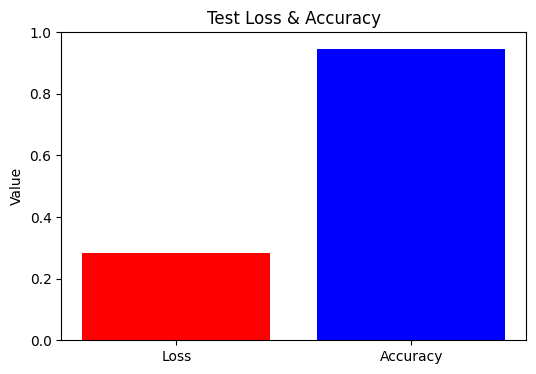

In [13]:
#accuracy

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển từ one-hot thành chỉ số lớp
y_true = np.argmax(y_test, axis=1)  # Chuyển ground truth từ one-hot thành chỉ số lớp

# Tính độ chính xác
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Độ chính xác (Accuracy): {accuracy * 100:.2f}%")

# Đánh giá model trên tập test
results = model.evaluate(X_test, y_test, verbose=1)
loss = results[0]  # Giá trị Loss
accuracy = results[1]  # Giá trị Accuracy

# Vẽ biểu đồ đơn giản
plt.figure(figsize=(6,4))
plt.bar(["Loss", "Accuracy"], [loss, accuracy], color=["red", "blue"])
plt.title("Test Loss & Accuracy")
plt.ylim(0, 1)
plt.ylabel("Value")
plt.show()


In [92]:
del labels

In [9]:
#test
# Load model
model = tf.keras.models.load_model("fully_model_100e.keras")

# Khởi tạo webcam
cap = cv2.VideoCapture(0)

# Danh sách các nhãn (A-Z, 0-9) 35 ký hiệu, không có 'O' nhưng thay thế = 0
labels = list("0123456789ABCDEFGHIKLMNPQRSTUVWXY")
# labels = list("0123456789")
# labels = list("ABCDEFGHI")
# labels = list("KLMNPQRST")
# labels = list("UVWXY")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Lấy kích thước khung hình
    h, w, _ = frame.shape

    # Chuyển ảnh sang RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Mediapipe xử lý ảnh
    results = hands.process(frame_rgb)
    cv2.putText(frame, "Press SPACE to capture, 'q' to exit", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Lấy tọa độ các điểm trên bàn tay
            x_min, y_min = w, h
            x_max, y_max = 0, 0

            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            # Mở rộng khung nhận diện để tránh cắt mất tay
            padding = int((x_max - x_min) * 0.2)
            x1, y1 = max(x_min - padding, 0), max(y_min - padding, 0)
            x2, y2 = min(x_max + padding, w), min(y_max + padding, h)

            # Vẽ khung chữ nhật quanh bàn tay
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

            # Cắt vùng bàn tay từ ảnh gốc
            roi = frame[y1:y2, x1:x2]

            # Resize ảnh về kích thước phù hợp với model
            if roi.shape[0] > 0 and roi.shape[1] > 0:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                img = cv2.resize(roi_rgb, (64, 64))
                img = img / 255.0  # Chuẩn hóa về [0,1]
                img = np.expand_dims(img, axis=0)  # Thêm batch dimension

            # Dự đoán ký hiệu tay
            predictions = model.predict(img)
            predicted_label = labels[np.argmax(predictions)]
            # predicted_index = np.argmax([predictions[0][0], predictions[0][1]])  # Chỉ lấy 2 giá trị đầu
            # predicted_label = labels[predicted_index]


            # Hiển thị kết quả trên màn hình
            cv2.putText(frame, f"Detected: {predicted_label}", (x1, y1 - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)

    # Hiển thị video
    cv2.imshow("Sign Language Detection", frame)

    # Nhấn 'q' để thoát
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng tài nguyên
cap.release()
cv2.destroyAllWindows()

In [10]:
#test model with capture

# Load model
model = tf.keras.models.load_model("fully_model_130e_with_Aug.keras")

# Khởi tạo webcam
cap = cv2.VideoCapture(0)
# Tăng độ sáng 
# cap.set(cv2.CAP_PROP_BRIGHTNESS, -1)  # Giá trị từ 0.0 đến 1.0 hoặc -1 đến 1 tùy theo loại camera

# Giảm độ sáng
# cap.set(cv2.CAP_PROP_BRIGHTNESS, 0.3)

# Mediapipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# Danh sách các nhãn
labels = list("0123456789ABCDEFGHIKLMNPQRSTUVWXY")

# Tạo thư mục lưu ảnh nếu chưa có
save_dir = "test"
os.makedirs(save_dir, exist_ok=True)

# Lấy số thứ tự lớn nhất trong thư mục test
existing_files = [f for f in os.listdir(save_dir) if f.endswith(".jpg")]
if existing_files:
    existing_numbers = [int(f.split(".")[0]) for f in existing_files]
    img_counter = max(existing_numbers) + 1
else:
    img_counter = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # cv2.putText(frame, "Press SPACE to capture, 'q' to exit", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            x_min, y_min = w, h
            x_max, y_max = 0, 0

            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            # Mở rộng khung nhận diện ban đầu
            padding = int((x_max - x_min) * 0.2)
            x1, y1 = max(x_min - padding, 0), max(y_min - padding, 0)
            x2, y2 = min(x_max + padding, w), min(y_max + padding, h)

            # Thêm padding lớn bao toàn bộ vùng cần chụp
            extra_padding = 45
            extra_padding_x = 40  # Tăng nhẹ chiều rộng
            extra_padding_y = 80  # Tăng nhẹ chiều cao

            x1_ext, y1_ext = max(x1 - extra_padding_x, 0), max(y1 - extra_padding_y, 0)
            x2_ext, y2_ext = min(x2 + extra_padding_x, w), min(y2 + extra_padding_y, h)


            # Vẽ khung chữ nhật quanh vùng nhận diện tay
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Khung nhỏ
            cv2.rectangle(frame, (x1_ext, y1_ext), (x2_ext, y2_ext), (255, 0, 0), 2)  # Khung lớn

            # Cắt vùng bàn tay từ ảnh gốc
            roi = frame[y1:y2, x1:x2]
            
            if roi.shape[0] > 0 and roi.shape[1] > 0:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                img = cv2.resize(roi_rgb, (64, 64))
                img = img / 255.0
                img = np.expand_dims(img, axis=0)

                # Dự đoán ký hiệu tay
                predictions = model.predict(img)
                predicted_label = labels[np.argmax(predictions)]
                
                # Hiển thị kết quả dự đoán trên màn hình
                cv2.putText(frame, f"CNN Model ", (x1, y1 - 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
                cv2.putText(frame, f"Detec: {predicted_label}", (x1, y1 - 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
    
    # Hiển thị video
    cv2.imshow("Sign Language Detection", frame)

    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
    elif key == ord(' '):  # Nhấn SPACE để chụp ảnh
        if results.multi_hand_landmarks:
            hand_region = frame[y1_ext:y2_ext, x1_ext:x2_ext]
            img_path = os.path.join(save_dir, f"{img_counter}.jpg")
            cv2.imwrite(img_path, hand_region)
            print(f"Saved {img_path}")
            img_counter += 1

cap.release()  # Giải phóng camera
cv2.destroyAllWindows()  # Đóng tất cả cửa sổ OpenCV


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

In [7]:
#test model with picture
# Load model CNN
model = tf.keras.models.load_model("fully_model_130e_with_Aug.keras")

# Danh sách các nhãn dự đoán
labels = list("0123456789ABCDEFGHIKLMNPQRSTUVWXY")

# Thư mục chứa ảnh test
test_folder = "pic_for_test"

# Duyệt qua tất cả ảnh trong thư mục
for file_name in os.listdir(test_folder):
    file_path = os.path.join(test_folder, file_name)

    # Đọc ảnh
    image = cv2.imread(file_path)
    if image is None:
        print(f"Không thể đọc ảnh: {file_name}")
        continue

    # Chuyển ảnh sang RGB và resize về đúng kích thước model yêu cầu (64x64)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(image_rgb, (64, 64)) / 255.0  # Chuẩn hóa ảnh
    img_resized = np.expand_dims(img_resized, axis=0)  # Thêm batch dimension

    # Dự đoán bằng model CNN
    predictions = model.predict(img_resized)
    predicted_label = labels[np.argmax(predictions)]

    print(f"Ảnh: {file_name} -> Dự đoán: {predicted_label}")

    # Hiển thị ảnh với kết quả dự đoán
    cv2.putText(image, f"Pred: {predicted_label}", (20, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Prediction", image)
    cv2.waitKey(1000)  # Hiển thị ảnh 1 giây trước khi đóng
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Ảnh: a.jpg -> Dự đoán: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Ảnh: b.jpg -> Dự đoán: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Ảnh: c.jpg -> Dự đoán: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Ảnh: d.jpg -> Dự đoán: D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Ảnh: e.jpg -> Dự đoán: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Ảnh: f.jpg -> Dự đoán: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Ảnh: g.jpg -> Dự đoán: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Ảnh: h.jpg -> Dự đoán: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Ảnh: i.jpg -> Dự đoán: I
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Ảnh: k.jpg -> Dự đoán: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Ảnh: l.jpg -> Dự đoán: L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Ảnh: m.jpg -> Dự đoán: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Ảnh: n.jpg -> Dự đoán: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Ảnh: o.jpg -> Dự đoán: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Ảnh: p.jpg -> Dự đoán: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Ảnh: q.jpg -

# Note có 1 số ký tự giống như O và 0 , W và 6 vì vậy phải xem xét xem là đang nói về đề tài nào để phân biệt 
# Sau khi hoàn thành nghiên cứu natural language để cải thiện đầu ra và tự nhận biết được nhưng ký tự tương đồng